## Setting up environment

In [1]:
# %matplotlib widget
# import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
plt.style.use('ggplot')

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, auc, f1_score, average_precision_score, make_scorer
from imblearn.over_sampling import SMOTE

# import the TC 10 dataset
gasNames = ['H_2', 'CH_4', 'C_2H_2', 'C_2H_4', 'C_2H_6', 'CO', 'CO_2']
duvalPos = pd.read_csv('./CSV/duvalPos.csv', names=gasNames)
duvalNeg = pd.read_csv('./CSV/duvalNeg.csv', names=gasNames)
duval_data = pd.concat([duvalPos, duvalNeg], ignore_index=True)
duval_labels = pd.DataFrame([1] * len(duvalPos) + [0] * len(duvalNeg))

# import the dataset by Mirowski and LeCun (2012)
duvalNeg_Mirowski = pd.read_csv('./CSV/duvalNeg_Mirowski_0.5.csv', names=gasNames)
mirowski_data = pd.concat([duvalPos, duvalNeg_Mirowski], ignore_index=True)
mirowski_labels = pd.DataFrame([1] * len(duvalPos) + [0] * len(duvalNeg_Mirowski))

# import the Hong Kong dataset
duvalNeg_personal = pd.read_csv('./Data_r1446/filtered_data.csv', names=gasNames, skiprows=1)
hk_data = pd.concat([duvalPos, duvalNeg_personal], ignore_index=True)
hk_labels = pd.DataFrame([1] * len(duvalPos) + [0] * len(duvalNeg_personal))

# create synthetic dataset
smote = SMOTE(sampling_strategy='minority')
smote_data, smote_labels = smote.fit_resample(duval_data, duval_labels)

### helper functions

In [2]:
def DGOA_PlotDGOA3D(X, y, axis_labels, fig, subplot_num, ax_title=''):
    (nrows, ncols, index) = subplot_num
    ax = fig.add_subplot(nrows, ncols, index, projection='3d')
    ax.scatter(X[X.columns[0]][y == 1], 
               X[X.columns[1]][y == 1], 
               X[X.columns[2]][y == 1], 
               c='r', label='positive')
    ax.scatter(X[X.columns[0]][y == 0], 
               X[X.columns[1]][y == 0], 
               X[X.columns[2]][y == 0], 
               c='g', label='negative')
    ax.set_xlabel(f'${axis_labels[0]}$')
    ax.set_ylabel(f'${axis_labels[1]}$')
    ax.set_zlabel(f'${axis_labels[2]}$')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)
    ax.set_title(f'{ax_title} ${axis_labels[0]}$, ${axis_labels[1]}$, ${axis_labels[2]}$')
    return ax

def plot_pr_curve(fig, subplot_num, *args, chart_title=''):
    (nrows, ncols, index) = subplot_num
    ax = fig.add_subplot(nrows, ncols, index)
    for arg in args:
        y_true, y_pred, title = arg[0], arg[1], arg[2]
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, y_pred)
        average_precision = average_precision_score(y_true, y_pred)
        
        ax.plot(recall, precision, label=f'{title} (ROC AUC = {roc_auc:.4f}, AP = {average_precision:.4f})')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'PR Curve{chart_title}')
    return ax

def plot_roc_curve(fig, subplot_num, *args, chart_title=''):
    (nrows, ncols, index) = subplot_num
    ax = fig.add_subplot(nrows, ncols, index)
    for arg in args:
        y_true, y_scores, title = arg[0], arg[1], arg[2]
        fpr, tpr, _ = roc_curve(y_true, y_scores)        
        ax.plot(fpr, tpr, label=f'{title}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve{chart_title}')
    return ax

models = {
    "knn": KNeighborsClassifier(),
    "random_forest": RandomForestClassifier(),
    "svc_linear": SVC(kernel='linear', probability=True, random_state=42),
    "svc_quad": SVC(kernel='poly', probability=True, random_state=42),
    "svc_rbf": SVC(kernel='rbf', probability=True, random_state=42),
    "neural_network": MLPClassifier(hidden_layer_sizes=(10,), activation='tanh', solver='sgd', max_iter=10000)
}

def create_pipeline(transform_func='yj', model='svc_rbf'):
    match transform_func:
        case 'yj':
            transform_func = PowerTransformer(method='yeo-johnson', standardize=False)
        case 'log':
            transform_func = FunctionTransformer(func=np.log1p, validate=False)        
    pipeline = make_pipeline(
            transform_func,
            StandardScaler(),
            models[model]
        )
    return pipeline

## TC 10 dataset visualised

A preliminary plots to see how the data look like

In [3]:
# make a X, y pair with all data, so all data are displayed on the same scale
all_labels = pd.concat([duval_data, mirowski_data, hk_data, smote_data])
all_labels.drop_duplicates(inplace=True)
all_labels = pd.concat([all_labels, duvalPos], ignore_index=True)
all_data = pd.DataFrame( [1] * len(duvalPos) + [0] * (1-len(duvalPos) ) )
X, y = all_labels, all_data[0]
axis_labels = X.columns
pipeline = Pipeline([
    ('yj_transform', PowerTransformer()),  # Yeo-Johnson transformation
    ('std_scaler', StandardScaler())       # StandardScaler
])
X = pd.DataFrame(pipeline.fit_transform(X))

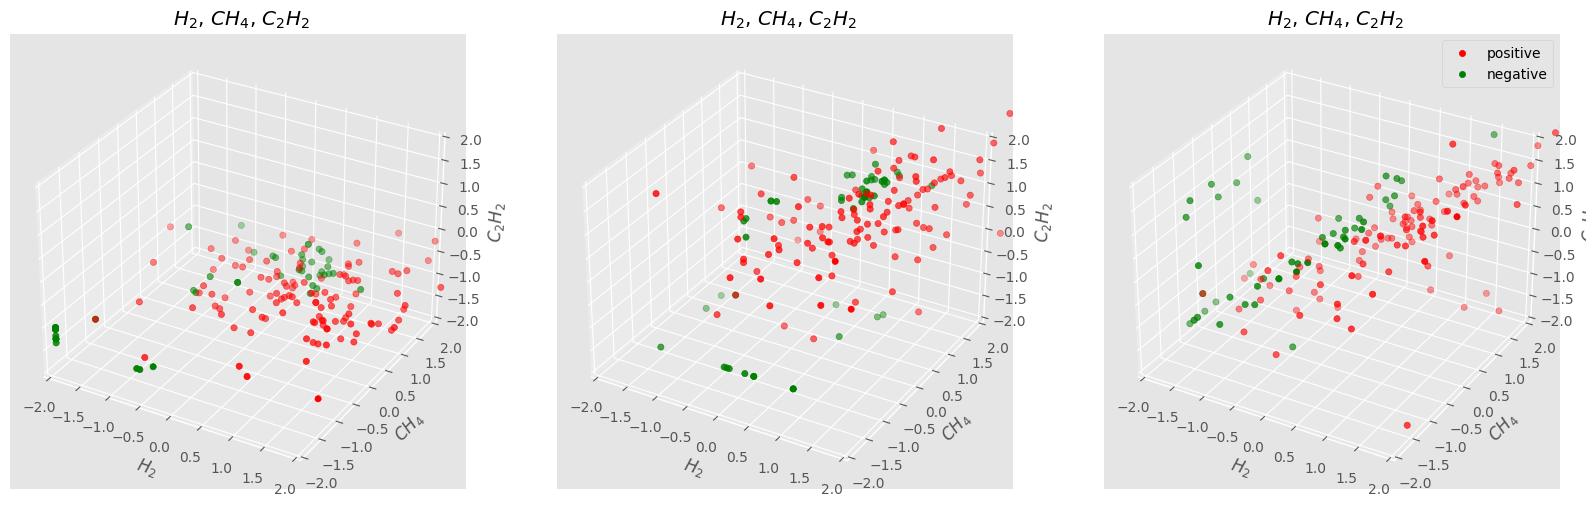

In [4]:
# Raw duval
X, y = duval_data, duval_labels[0]
axis_labels = X.columns
X = pd.DataFrame(pipeline.transform(X))
fig = plt.figure(figsize=(20,20), dpi=100)
DGOA_PlotDGOA3D(X[[0, 5, 6]], y, axis_labels, fig, (1,3,1), ax_title='')
DGOA_PlotDGOA3D(X[[2, 3, 4]], y, axis_labels, fig, (1,3,2), ax_title='')
DGOA_PlotDGOA3D(X[[0, 1, 3]], y, axis_labels, fig, (1,3,3), ax_title='')
plt.legend()

# # Raw duval + random sampling (Mirowski)
# X, y = mirowski_data, mirowski_labels[0]
# axis_labels = X.columns
# X = pd.DataFrame(pipeline.transform(X))
# DGOA_PlotDGOA3D(X[[0, 5, 6]], y, axis_labels, fig, (4,3,4), ax_title='Raw duval + random sampling (Mirowski)\n')
# DGOA_PlotDGOA3D(X[[2, 3, 4]], y, axis_labels, fig, (4,3,5), ax_title='Raw duval + random sampling (Mirowski)\n')
# DGOA_PlotDGOA3D(X[[0, 1, 3]], y, axis_labels, fig, (4,3,6), ax_title='Raw duval + random sampling (Mirowski)\n')
# plt.legend()

# # Raw duval + MTR data
# X, y = hk_data, hk_labels[0]
# axis_labels = X.columns
# X = pd.DataFrame(pipeline.transform(X))
# DGOA_PlotDGOA3D(X[[0, 5, 6]], y, axis_labels, fig, (4,3,7), ax_title='Raw duval + MTR data\n')
# DGOA_PlotDGOA3D(X[[2, 3, 4]], y, axis_labels, fig, (4,3,8), ax_title='Raw duval + MTR data\n')
# DGOA_PlotDGOA3D(X[[0, 1, 3]], y, axis_labels, fig, (4,3,9), ax_title='Raw duval + MTR data\n')
# plt.legend()

# # Raw duval + MTR data
# X, y = smote_data, smote_labels[0]
# axis_labels = X.columns
# X = pd.DataFrame(pipeline.transform(X))
# DGOA_PlotDGOA3D(X[[0, 5, 6]], y, axis_labels[[0, 5, 6]], fig, (4,3,10), ax_title='Raw duval + synthetic data\n')
# DGOA_PlotDGOA3D(X[[2, 3, 4]], y, axis_labels[[2, 3, 4]], fig, (4,3,11), ax_title='Raw duval + synthetic data\n')
# DGOA_PlotDGOA3D(X[[0, 1, 3]], y, axis_labels[[0, 1, 3]], fig, (4,3,12), ax_title='Raw duval + synthetic data\n')
# plt.legend()
plt.show()
plt.close()

## Compare different preprocessing

Use RBF SVC and SMOTE dataset. Compare performance of no transform, log transform, YJ transform.

Gridsearch for the best YJ hyperparameters.

In [5]:
# Custom scoring function for precision-recall AUC
def pr_auc_score(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

pipeline = Pipeline([
    ('yj_transform', PowerTransformer()),
    ('z_transform', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True))
])

# Parameters for HalvingGridSearchCV
param_grid = {
    'yj_transform__method': ['yeo-johnson'],
    'svm__C': np.logspace(-1, 1, 10),
    'svm__gamma': np.logspace(-1, 1, 10)
}

halving_grid_search = HalvingGridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
halving_grid_search.fit(smote_data, smote_labels[0])

# best params for the Yeo-Johnson transform
best_pipeline = halving_grid_search.best_estimator_
best_yj_params = halving_grid_search.best_params_['yj_transform__method']
best_pipeline.set_params(yj_transform__method=best_yj_params)

# cross-validation with best pipeline
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'roc_auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'pr_auc': make_scorer(pr_auc_score),
    'f1': make_scorer(f1_score)
}

cv_results_yj = cross_validate(best_pipeline, smote_data, smote_labels[0], cv=5, scoring=scoring)

# pipeline for no transform
pipeline_no_transform = Pipeline([
    ('z_transform', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True))
])
# cross-validation with no transform
cv_results_no_transform = cross_validate(pipeline_no_transform, smote_data, smote_labels[0], cv=5, scoring=scoring)

# pipeline for log transform
pipeline_log_transform = Pipeline([
    ('log_transform', FunctionTransformer(np.log1p)),
    ('z_transform', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True))
])
# cross-validation with log transform
cv_results_log_transform = cross_validate(pipeline_log_transform, smote_data, smote_labels[0], cv=5, scoring=scoring)

In [6]:
results_list = []
results_list.append({
    'Architecture': 'RBF',
    'Dataset': 'SMOTE',
    'Preprocessing': 'No Transform',
    'Accuracy': np.mean(cv_results_no_transform['test_accuracy']),
    'ROC AUC': np.mean(cv_results_no_transform['test_roc_auc']),
    'Precision': np.mean(cv_results_no_transform['test_precision']),
    'Recall': np.mean(cv_results_no_transform['test_recall']),
    'PR AUC': np.mean(cv_results_no_transform['test_pr_auc']),
    'F1 Score': np.mean(cv_results_no_transform['test_f1'])
})
results_list.append({
    'Architecture': 'RBF',
    'Dataset': 'SMOTE',
    'Preprocessing': 'Log Transform',
    'Accuracy': np.mean(cv_results_log_transform['test_accuracy']),
    'ROC AUC': np.mean(cv_results_log_transform['test_roc_auc']),
    'Precision': np.mean(cv_results_log_transform['test_precision']),
    'Recall': np.mean(cv_results_log_transform['test_recall']),
    'PR AUC': np.mean(cv_results_log_transform['test_pr_auc']),
    'F1 Score': np.mean(cv_results_log_transform['test_f1'])
})
results_list.append({
    'Architecture': 'RBF',
    'Dataset': 'SMOTE',
    'Preprocessing': 'YJ Transform',
    'Accuracy': np.mean(cv_results_yj['test_accuracy']),
    'ROC AUC': np.mean(cv_results_yj['test_roc_auc']),
    'Precision': np.mean(cv_results_yj['test_precision']),
    'Recall': np.mean(cv_results_yj['test_recall']),
    'PR AUC': np.mean(cv_results_yj['test_pr_auc']),
    'F1 Score': np.mean(cv_results_yj['test_f1'])
})
display(pd.DataFrame(results_list))
print("Best parameters for YJ transform:", halving_grid_search.best_params_)

,Architecture,Dataset,Preprocessing,Accuracy,ROC AUC,Precision,Recall,PR AUC,F1 Score
0,RBF,SMOTE,No Transform,0.8565,0.8574,0.9761,0.7322,0.9217,0.8232
1,RBF,SMOTE,Log Transform,0.9113,0.9101,0.9390,0.8895,0.9416,0.9082
2,RBF,SMOTE,YJ Transform,0.9705,0.9701,0.9760,0.9656,0.9793,0.9701


Best parameters for YJ transform: {'svm__C': 3.593813663804626, 'svm__gamma': 0.774263682681127, 'yj_transform__method': 'yeo-johnson'}


Use RBF SVC and TC 10 dataset. Compare performance of no transform, log transform, YJ transform.

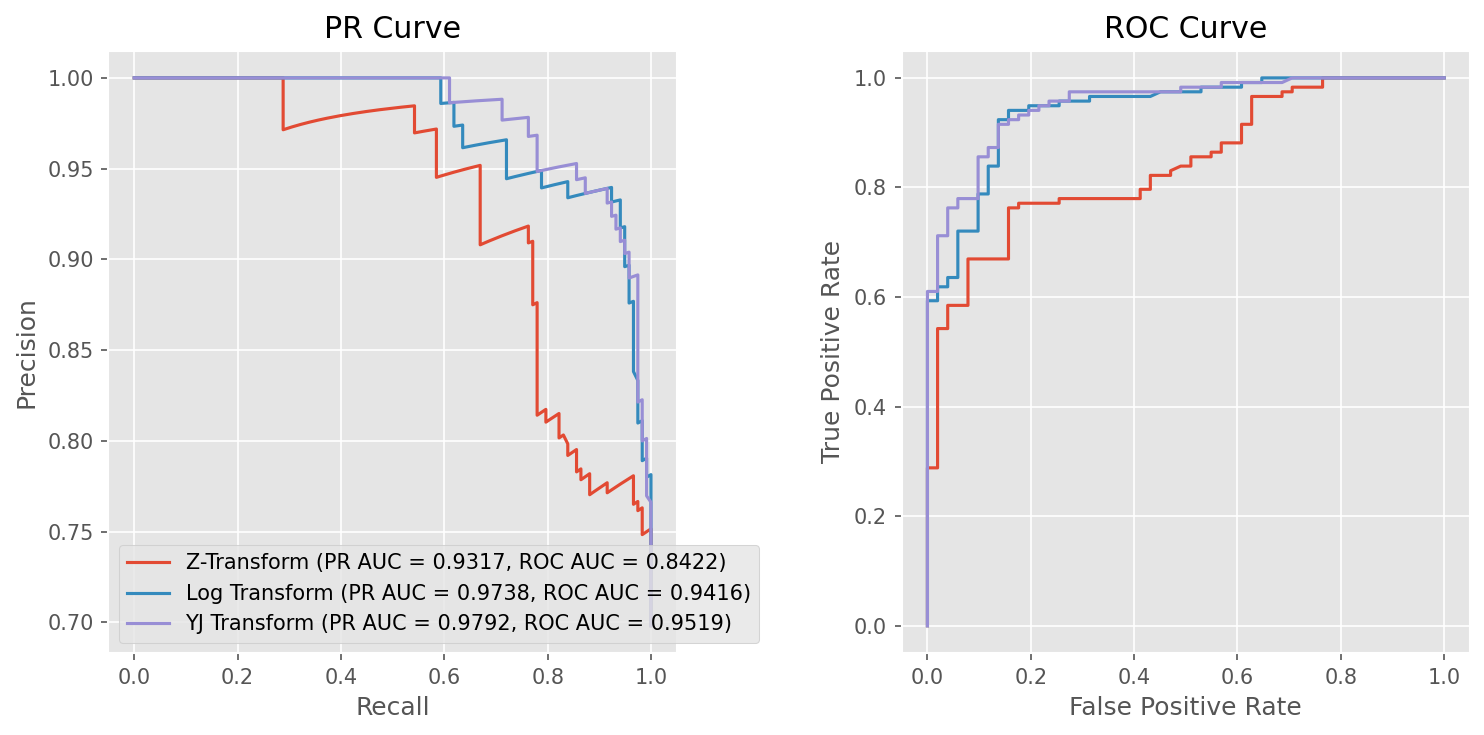

In [7]:
X, y = duval_data, duval_labels[0]

pipeline_z_transform = Pipeline([
    ('z_transform', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True))
])
pipeline_with_log = create_pipeline('log')
pipeline_with_yj = create_pipeline('yj')

y_scores_z_transform = cross_val_predict(pipeline_z_transform, X, y, method='predict_proba')[:, 1]
y_scores_with_log = cross_val_predict(pipeline_with_log, X, y, method='predict_proba')[:, 1]
y_scores_with_yj = cross_val_predict(pipeline_with_yj, X, y, method='predict_proba')[:, 1]


plt.figure(figsize=(10, 5), dpi=150)
plt.subplot(1, 2, 1)

# PR curve for z-transform
precision_z, recall_z, _ = precision_recall_curve(y, y_scores_z_transform)
pr_auc_z = auc(recall_z, precision_z)
fpr_z, tpr_z, _ = roc_curve(y, y_scores_z_transform)
roc_auc_z = auc(fpr_z, tpr_z)
plt.plot(recall_z, precision_z, label=f'Z-Transform (PR AUC = {pr_auc_z:.4f}, ROC AUC = {roc_auc_z:.4f})')
# PR curve for log transform
precision_log, recall_log, _ = precision_recall_curve(y, y_scores_with_log)
pr_auc_log = auc(recall_log, precision_log)
fpr_log, tpr_log, _ = roc_curve(y, y_scores_with_log)
roc_auc_log = auc(fpr_log, tpr_log)
plt.plot(recall_log, precision_log, label=f'Log Transform (PR AUC = {pr_auc_log:.4f}, ROC AUC = {roc_auc_log:.4f})')
# PR curve for yj transform
precision_yj, recall_yj, _ = precision_recall_curve(y, y_scores_with_yj)
pr_auc_yj = auc(recall_yj, precision_yj)
fpr_yj, tpr_yj, _ = roc_curve(y, y_scores_with_yj)
roc_auc_yj = auc(fpr_yj, tpr_yj)
plt.plot(recall_yj, precision_yj, label=f'YJ Transform (PR AUC = {pr_auc_yj:.4f}, ROC AUC = {roc_auc_yj:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend(loc=3)

plt.subplot(1, 2, 2)
# ROC curve for z-transform
fpr_z, tpr_z, _ = roc_curve(y, y_scores_z_transform)
roc_auc_z = auc(fpr_z, tpr_z)
plt.plot(fpr_z, tpr_z, label=f'Z-Transform')
# ROC curve for log transform
fpr_log, tpr_log, _ = roc_curve(y, y_scores_with_log)
roc_auc_log = auc(fpr_log, tpr_log)
plt.plot(fpr_log, tpr_log, label=f'Log Transform')
# ROC curve for yeo-johnson transform
fpr_yj, tpr_yj, _ = roc_curve(y, y_scores_with_yj)
roc_auc_yj = auc(fpr_yj, tpr_yj)
plt.plot(fpr_yj, tpr_yj, label=f'YJ Transform (ROC AUC)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

plt.tight_layout()
plt.show()

## Examine data leakage

Use RBF SVC and dataset from Mirowski and LeCun (2012). Compare performance of z-transform before (data leakage) and after (no leakage) train-test split.

In [8]:
X, y = mirowski_data, mirowski_labels[0]

# z-transform before train-test split (Data Leakage)
scaler_leakage = StandardScaler()
X_scaled_leakage = scaler_leakage.fit_transform(X)
X_train_leakage, X_test_leakage, y_train_leakage, y_test_leakage = train_test_split(X_scaled_leakage, y, test_size=0.2, random_state=42)

svm_leakage = SVC(kernel='rbf')
svm_leakage.fit(X_train_leakage, y_train_leakage)

y_pred_train_leakage = svm_leakage.predict(X_train_leakage)
y_pred_test_leakage = svm_leakage.predict(X_test_leakage)
# Accuracy and F1 Score (Data Leakage)
accuracy_leakage_train = accuracy_score(y_train_leakage, y_pred_train_leakage)
accuracy_leakage_test = accuracy_score(y_test_leakage, y_pred_test_leakage)
f1_leakage_train = f1_score(y_train_leakage, y_pred_train_leakage)
f1_leakage_test = f1_score(y_test_leakage, y_pred_test_leakage)

# z-transform after train-test split (No Data Leakage)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler_no_leakage = StandardScaler()
X_train_scaled = scaler_no_leakage.fit_transform(X_train)
X_test_scaled = scaler_no_leakage.transform(X_test)

svm_no_leakage = SVC(kernel='rbf')
svm_no_leakage.fit(X_train_scaled, y_train)

y_pred_train_no_leakage = svm_no_leakage.predict(X_train_scaled)
y_pred_test_no_leakage = svm_no_leakage.predict(X_test_scaled)

# Accuracy and F1 Score (No Data Leakage)
accuracy_no_leakage_train = accuracy_score(y_train, y_pred_train_no_leakage)
accuracy_no_leakage_test = accuracy_score(y_test, y_pred_test_no_leakage)
f1_no_leakage_train = f1_score(y_train, y_pred_train_no_leakage)
f1_no_leakage_test = f1_score(y_test, y_pred_test_no_leakage)

In [9]:
results_list = []
results_list.append({
    'Architecture': 'RBF',
    'Dataset': 'mirowski',
    'Preprocessing': 'Data Leakage',
    'Accuracy': accuracy_leakage_test,
    'ROC AUC': roc_auc_score(y_test_leakage, y_pred_test_leakage),
    'Precision': precision_score(y_test_leakage, y_pred_test_leakage),
    'Recall': recall_score(y_test_leakage, y_pred_test_leakage),
    'PR AUC': average_precision_score(y_test_leakage, y_pred_test_leakage),
    'F1 Score': f1_leakage_test
})
results_list.append({
    'Architecture': 'RBF',
    'Dataset': 'mirowski',
    'Preprocessing': 'No Data Leakage',
    'Accuracy': accuracy_no_leakage_test,
    'ROC AUC': roc_auc_score(y_test, y_pred_test_no_leakage),
    'Precision': precision_score(y_test, y_pred_test_no_leakage),
    'Recall': recall_score(y_test, y_pred_test_no_leakage),
    'PR AUC': average_precision_score(y_test, y_pred_test_no_leakage),
    'F1 Score': f1_no_leakage_test
})

display(pd.DataFrame(results_list))

,Architecture,Dataset,Preprocessing,Accuracy,ROC AUC,Precision,Recall,PR AUC,F1 Score
0,RBF,mirowski,Data Leakage,0.8298,0.8462,0.7241,1.0000,0.7241,0.8400
1,RBF,mirowski,No Data Leakage,0.8298,0.8462,0.7241,1.0000,0.7241,0.8400


## Compare different datasets

Use RBF SVC and YJ transform, examine model performance on different datasets.

In [10]:
datasets = {
    'duval': (duval_data, duval_labels[0]),
    'mirowski': (mirowski_data, mirowski_labels[0]),
    'personal': (hk_data, hk_labels[0]),
    'smote': (smote_data, smote_labels[0])
}
pipeline = Pipeline([
    ('yj_transform', PowerTransformer(method='yeo-johnson')),
    ('z_transform', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True))
])
# scoring metrics for cross-validation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'roc_auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'pr_auc': make_scorer(average_precision_score),
    'f1': make_scorer(f1_score)
}

results_list = []

for dataset_name, (X, y) in datasets.items():
    # cross-validation
    cv_results = cross_validate(pipeline, X, y, cv=5, scoring=scoring)
    # mean scores
    cv_accuracy_mean = np.mean(cv_results['test_accuracy'])
    cv_roc_auc_mean = np.mean(cv_results['test_roc_auc'])
    cv_precision_mean = np.mean(cv_results['test_precision'])
    cv_recall_mean = np.mean(cv_results['test_recall'])
    cv_pr_auc_mean = np.mean(cv_results['test_pr_auc'])
    cv_f1_mean = np.mean(cv_results['test_f1'])
    
    results_list.append({
        'Architecture': 'RBF',
        'Dataset': dataset_name,
        'Preprocessing': 'YJ Transform + Z-Transform',
        'Accuracy': cv_accuracy_mean,
        'ROC AUC': cv_roc_auc_mean,
        'Precision': cv_precision_mean,
        'Recall': cv_recall_mean,
        'PR AUC': cv_pr_auc_mean,
        'F1': cv_f1_mean
    })

In [11]:
display(pd.DataFrame(results_list))

,Architecture,Dataset,Preprocessing,Accuracy,ROC AUC,Precision,Recall,PR AUC,F1
0,RBF,duval,YJ Transform + Z-Transform,0.8934,0.8812,0.9343,0.9152,0.9143,0.9228
1,RBF,mirowski,YJ Transform + Z-Transform,0.9660,0.9656,0.9611,0.9746,0.9499,0.9671
2,RBF,personal,YJ Transform + Z-Transform,0.9930,0.9924,0.9840,0.9913,0.9777,0.9874
3,RBF,smote,YJ Transform + Z-Transform,0.9154,0.9145,0.9483,0.8899,0.8951,0.9131


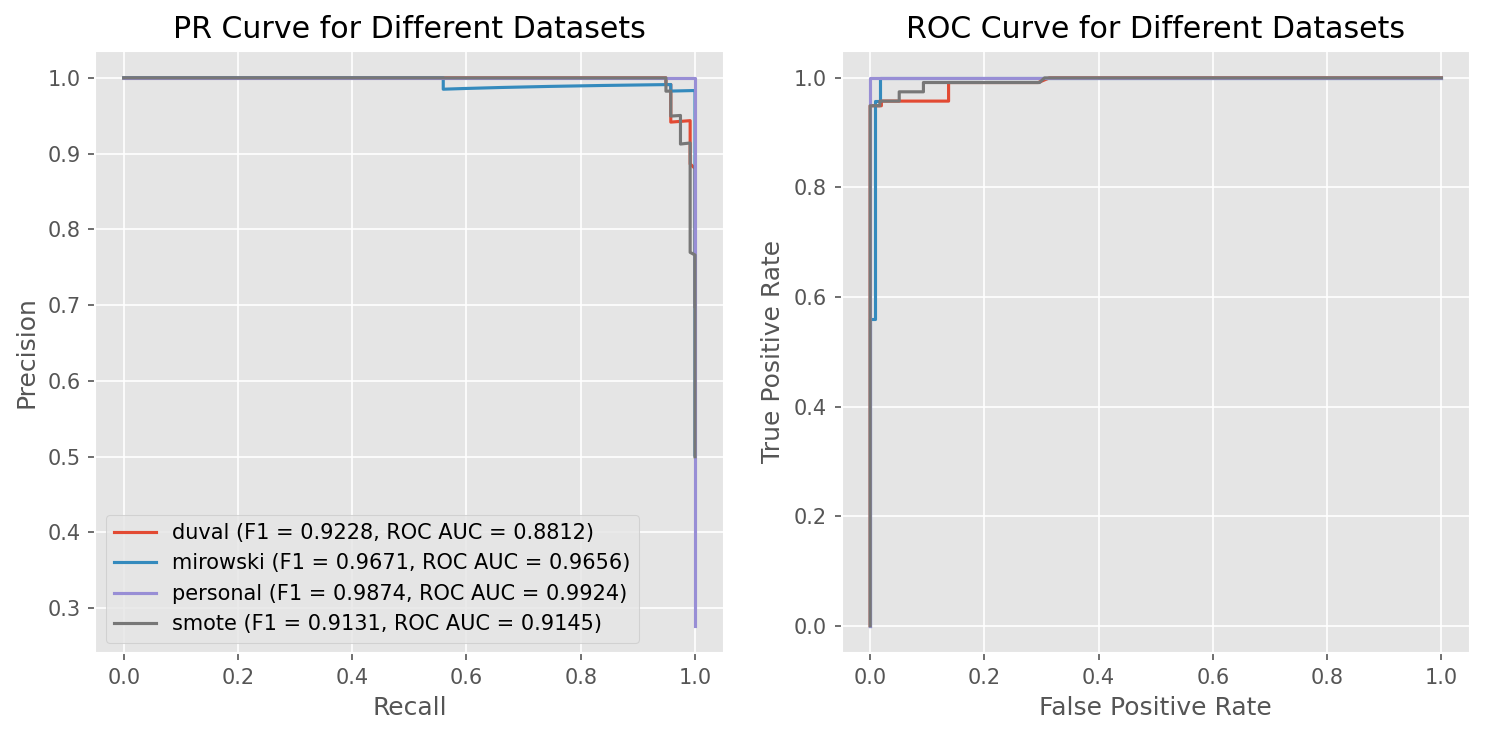

In [12]:
plt.figure(figsize=(10, 5), dpi=150)
# Plot PR curve
plt.subplot(1, 2, 1)
for dataset_name, (X, y) in datasets.items():
    cv_results = cross_validate(pipeline, X, y, cv=5, scoring=scoring)
    cv_roc_mean = np.mean(cv_results['test_roc_auc'])
    cv_f1_mean = np.mean(cv_results['test_f1'])
    
    pipeline.fit(X, y)    
    y_prob = pipeline.predict_proba(X)[:, 1]    
    precision, recall, _ = precision_recall_curve(y, y_prob)

    plt.plot(recall, precision, label=f'{dataset_name} (F1 = {cv_f1_mean:.4f}, ROC AUC = {cv_roc_mean:.4f})')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for Different Datasets')

# Plot ROC curve
plt.subplot(1, 2, 2)
for dataset_name, (X, y) in datasets.items():
    cv_results = cross_validate(pipeline, X, y, cv=5, scoring=['roc_auc', 'average_precision'])
    cv_roc_mean = np.mean(cv_results['test_roc_auc'])

    pipeline.fit(X, y)
    y_prob = pipeline.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{dataset_name}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Datasets')

plt.tight_layout()
plt.show()

## Compare different model

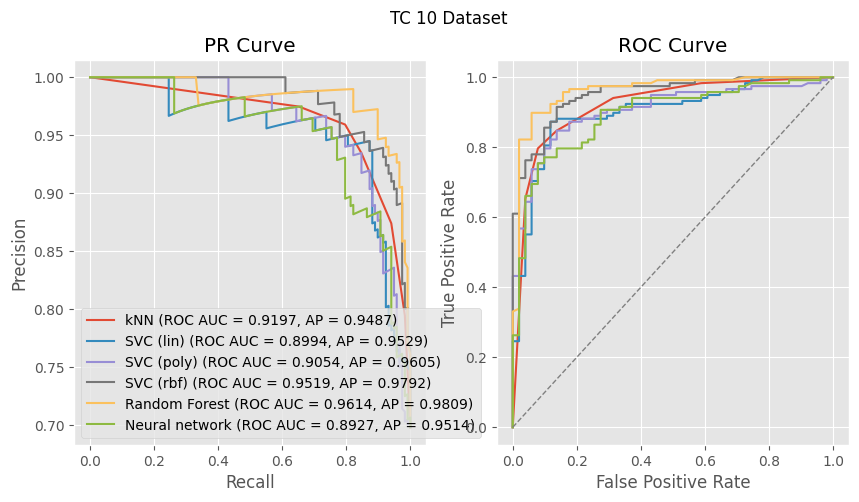

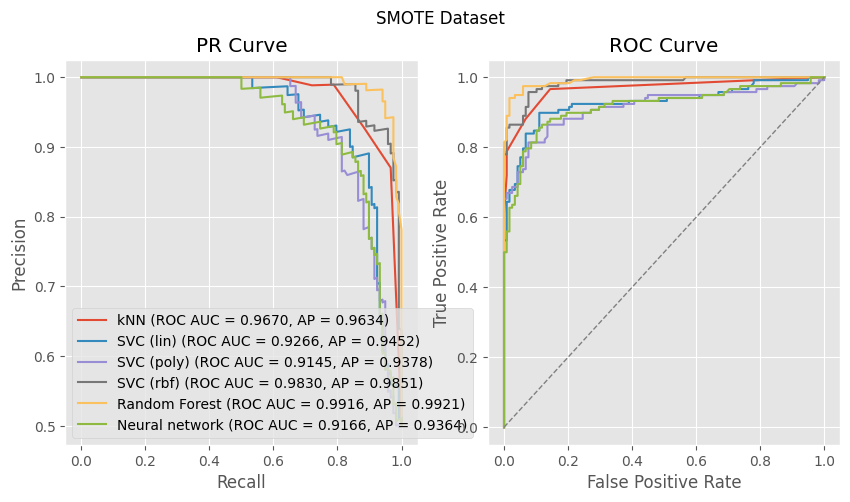

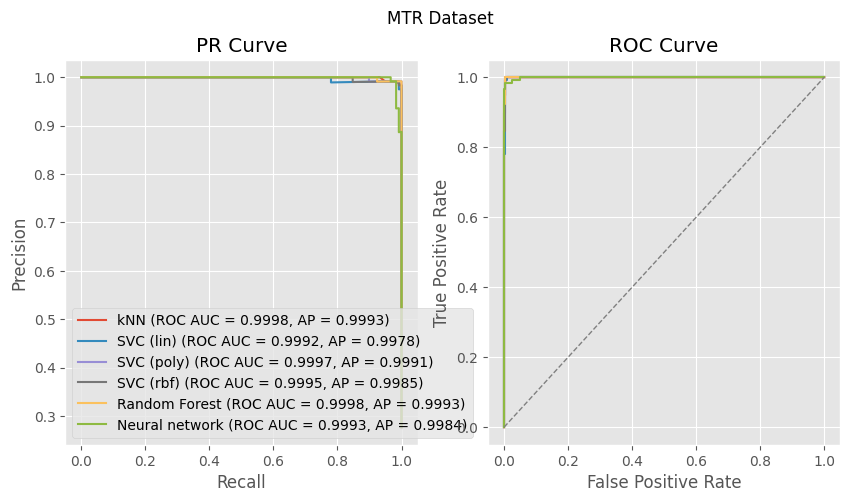

In [13]:
def compare_models(X, y, chart_title=''):
    pipeline_knn = create_pipeline(model='knn')
    pipeline_svclin = create_pipeline(model='svc_linear')
    pipeline_svcquad = create_pipeline(model='svc_quad')
    pipeline_svcrbf = create_pipeline(model='svc_rbf')
    pipeline_random_forest = create_pipeline(model='random_forest')
    pipeline_nn = create_pipeline(model='neural_network')

    y_scores_knn = cross_val_predict(pipeline_knn, X, y, method='predict_proba')[:, 1]
    y_scores_svclin = cross_val_predict(pipeline_svclin, X, y, method='predict_proba')[:, 1]
    y_scores_svcquad = cross_val_predict(pipeline_svcquad, X, y, method='predict_proba')[:, 1]
    y_scores_svcrbf = cross_val_predict(pipeline_svcrbf, X, y, method='predict_proba')[:, 1]
    y_scores_randomforest = cross_val_predict(pipeline_random_forest, X, y, method='predict_proba')[:, 1]
    y_scores_nn = cross_val_predict(pipeline_nn, X, y, method='predict_proba')[:, 1]

    fig = plt.figure(figsize=(10,5),dpi=100)
    fig.suptitle(f'{chart_title} Dataset')
    plot_pr_curve(
        fig,
        (1,2,1),
        [y, y_scores_knn, 'kNN'], 
        [y, y_scores_svclin, 'SVC (lin)'], 
        [y, y_scores_svcquad, 'SVC (poly)'], 
        [y, y_scores_svcrbf, 'SVC (rbf)'], 
        [y, y_scores_randomforest, 'Random Forest'], 
        [y, y_scores_nn, 'Neural network'], 
    )
    plt.legend(loc=3)

    plot_roc_curve(
        fig,
        (1,2,2),
        [y, y_scores_knn, 'kNN'], 
        [y, y_scores_svclin, 'SVC (lin)'], 
        [y, y_scores_svcquad, 'SVC (poly)'], 
        [y, y_scores_svcrbf, 'SVC (rbf)'], 
        [y, y_scores_randomforest, 'Random Forest'], 
        [y, y_scores_nn, 'Neural network'], 
    )
    plt.plot([0, 1], [0, 1], color="grey", linestyle="--", lw=1)
    plt.show()
    plt.close()
    return [y_scores_knn, y_scores_svclin, y_scores_svcquad, y_scores_svcrbf, y_scores_randomforest, y_scores_nn]

X, y = duval_data, duval_labels[0]
y_scores_duval = compare_models(X, y, 'TC 10')

X, y = smote_data, smote_labels[0]
y_scores_smote = compare_models(X, y, 'SMOTE')

X, y = hk_data, hk_labels[0]
y_scores_mtr = compare_models(X, y, 'MTR')

In [14]:
def calculate_metrics(y_true, y_scores):
    accuracy = accuracy_score(y_true, y_scores.round())
    precision = precision_score(y_true, y_scores.round())
    recall = recall_score(y_true, y_scores.round())
    roc_auc = roc_auc_score(y_true, y_scores)
    pr_auc = average_precision_score(y_true, y_scores)
    f1 = f1_score(y_true, y_scores.round())
    return accuracy, precision, recall, roc_auc, pr_auc, f1

results_list = []

datasets = {
    'TC 10': duval_labels[0],
    'SMOTE': smote_labels[0],
    'MTR': hk_labels[0]
}

# Define the model names
models = ['kNN', 'SVC (lin)', 'SVC (poly)', 'SVC (rbf)', 'Random Forest', 'Neural network']

for dataset_name, y_true in datasets.items():
    if dataset_name == 'TC 10':
        y_scores = y_scores_duval
    elif dataset_name == 'SMOTE':
        y_scores = y_scores_smote
    elif dataset_name == 'MTR':
        y_scores = y_scores_mtr
        
    for model_name, scores in zip(models, y_scores):
        accuracy, precision, recall, roc_auc, pr_auc, f1 = calculate_metrics(y_true, scores)
        
        results_list.append({
            'Architecture': model_name,
            'Dataset': dataset_name,
            'Preprocessing': 'YJ, z transform',
            'Accuracy': accuracy,
            'ROC AUC': roc_auc,
            'Precision': precision,
            'Recall': recall,
            'PR AUC': pr_auc,
            'F1': f1
        })

In [15]:
display(pd.DataFrame(results_list))

,Architecture,Dataset,Preprocessing,Accuracy,ROC AUC,Precision,Recall,PR AUC,F1
0,kNN,TC 10,"YJ, z transform",0.8521,0.9197,0.9346,0.8475,0.9487,0.8889
1,SVC (lin),TC 10,"YJ, z transform",0.8402,0.8994,0.8889,0.8814,0.9529,0.8851
2,SVC (poly),TC 10,"YJ, z transform",0.8166,0.9054,0.8321,0.9237,0.9605,0.8755
3,SVC (rbf),TC 10,"YJ, z transform",0.8994,0.9519,0.9391,0.9153,0.9792,0.9270
4,Random Forest,TC 10,"YJ, z transform",0.9172,0.9614,0.9333,0.9492,0.9809,0.9412
5,Neural network,TC 10,"YJ, z transform",0.8343,0.8927,0.8814,0.8814,0.9514,0.8814
6,kNN,SMOTE,"YJ, z transform",0.8898,0.9670,0.9894,0.7881,0.9634,0.8774
7,SVC (lin),SMOTE,"YJ, z transform",0.8814,0.9266,0.9245,0.8305,0.9452,0.8750
8,SVC (poly),SMOTE,"YJ, z transform",0.8475,0.9145,0.8661,0.8220,0.9378,0.8435
9,SVC (rbf),SMOTE,"YJ, z transform",0.9153,0.9830,0.9298,0.8983,0.9851,0.9138
